In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import warnings
warnings.filterwarnings('ignore')

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:

# len(calib['So'].join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi']]).dropna())

In [4]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'PGC1', 'Nest',
       'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel', 'Vls', 'v3k', 'f',
       'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc', 'g***', 'r***', 'i***',
       'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE', 'GLong', 'GLat', 'SGL', 'SGB',
       'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg', 'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10154


,flag,DM_av,DM_riz,eDM_riz,DM_W1,eDM_W1,PGC1,Nest,logMs_riz,logMs_W1,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.54,NaN,NaN,34.54,0.28,73150,200275,NaN,10.917,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.44,33.35,0.20,33.53,0.19,120,202766,9.213,9.122,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.02,NaN,NaN,35.02,0.23,12,210177,NaN,10.475,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.66,34.60,0.26,34.72,0.25,16,211419,10.205,10.180,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.66,33.62,0.26,33.71,0.25,55,0,9.184,9.141,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [5]:
gg = pd.read_csv("../calibrators/TF_calibration_parameters_bar.200527", sep='|')

for col in gg.columns:
    newcol = col.strip()
    gg.rename(columns={col:newcol}, inplace=True)

gg = gg.set_index("pgc")

df = df.join(gg[["w1_sss", "w2_sss", "mu50", "P0_w2", "c21w", "Wba"]])

gg.head()

,Name,Vhel,Vls,u,g,r,i,z,w1,w2,...,Sqlt,Wqlt,u_sss,g_sss,r_sss,i_sss,z_sss,w1_sss,w2_sss,R_source
pgc,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,0.00,0.00,0.00,0.00,0.00,11.86,12.49,...,0,5,0.00,0.00,0.00,0.00,0.00,11.89,12.52,2
4,PGC000004,4458.0,4706.1,17.57,16.43,15.91,15.57,15.42,16.06,16.42,...,5,4,16.30,15.59,15.33,15.12,15.07,16.07,16.44,2
12,PGC000012,6531.0,6667.6,0.00,0.00,0.00,0.00,0.00,13.60,14.20,...,0,5,0.00,0.00,0.00,0.00,0.00,13.59,14.23,2
16,PGC000016,5713.0,5855.1,16.08,14.83,14.21,13.86,13.61,13.98,14.67,...,5,5,15.40,14.36,13.86,13.58,13.40,13.99,14.70,2
55,UGC12898,4779.0,5052.2,16.82,16.08,15.71,15.50,15.40,16.18,16.60,...,5,4,15.94,15.53,15.32,15.22,15.17,16.20,16.63,2


In [6]:
hh = pd.read_csv("../calibrators/ESN_HI_catal_all.csv", sep=',')

for col in hh.columns:
    newcol = col.strip()
    hh.rename(columns={col:newcol}, inplace=True)

hh = hh.set_index("pgc")

df = df.join(hh[["R50_w1", "R50_w2"]])

hh.head()

,Name,Vhel,Vls,Wmx,eWmx,logWimx,logWimx_e,F21,eF21,m21,...,Sba,Wba,Ty,ebv,inc,inc_e,inc_n,flag,Sqlt,Wqlt
pgc,,,,,,,,,,,,,,,,,,,,,
2,UGC12889,5017.0,5309.5,437.0,16.000,2.744,0.029,4.730,0.804,15.713,...,0.00,0.66,3.1,0.000,52,4,5,0,0,5
4,PGC000004,4458.0,4706.1,154.0,3.881,2.189,0.011,1.927,0.135,16.688,...,0.24,0.33,5.0,0.091,85,2,7,0,5,4
12,PGC000012,6531.0,6667.6,400.0,19.000,2.606,0.021,3.400,0.578,16.071,...,0.22,0.36,1.3,0.046,82,3,9,0,0,5
16,PGC000016,5713.0,5855.1,297.0,14.142,2.515,0.025,1.195,0.203,17.207,...,0.52,0.64,-0.1,0.031,65,4,8,0,5,5
55,UGC12898,4779.0,5052.2,179.0,10.000,2.260,0.025,4.540,0.318,15.757,...,0.32,0.46,5.9,0.050,80,3,8,0,5,4


In [7]:
df["mu50_w1"] = df["w1***"]+2.5*np.log10(2.*np.pi*(df.R50_w2*60)**2)-2.5*np.log10(df.Wba)

df[["w1***", "w1_sss", "w2_sss", "mu50", "P0_w2", "c21w", "Wba", "R50_w1", "R50_w2", "mu50_w1"]].head(20)

,w1***,w1_sss,w2_sss,mu50,P0_w2,c21w,Wba,R50_w1,R50_w2,mu50_w1
PGC,,,,,,,,,,
2,11.89,11.89,12.52,22.41,2.02,3.18,0.66,0.51,0.51,21.765197
4,16.07,16.07,16.44,26.12,-2.75,0.25,0.33,0.27,0.33,25.752491
12,13.59,13.59,14.23,23.23,0.56,1.83,0.36,0.25,0.25,22.575150
16,13.99,13.99,14.70,22.59,0.92,2.50,0.64,0.21,0.20,21.865906
55,16.20,16.20,16.63,25.43,-2.83,-0.87,0.46,0.22,0.26,25.004178
68,15.03,15.03,15.54,23.27,-0.35,1.34,0.66,0.19,0.19,22.761114
70,13.54,13.54,14.11,25.31,-0.74,0.93,0.14,0.43,0.43,24.728228
76,13.23,13.23,13.81,23.05,0.75,1.96,0.47,0.30,0.32,22.461711
92,NaN,0.00,0.00,25.05,0.00,-0.58,0.41,0.00,0.00,NaN


In [8]:
df['Vmod'] = df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']
df['iw1'] = df['i***'] - df['w1***']

In [9]:
len(df)

10154

In [10]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [11]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

,Flux
PGC,
2,4.73
4,1.85
6,NaN
12,3.40
16,1.19


In [12]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"Vls":"V3k"})

df.head()

,flag,DM_av,DM_riz,eDM_riz,DM_W1,eDM_W1,PGC1,Nest,logMs_riz,logMs_W1,...,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,iw1,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.54,NaN,NaN,34.54,0.28,73150,200275,NaN,10.917,...,NaN,NaN,NaN,NaN,-22.459020,NaN,NaN,NaN,NaN,4.73
4,1,33.44,33.35,0.20,33.53,0.19,120,202766,9.213,9.122,...,-18.421709,-18.681709,-18.891709,-18.941709,-17.941709,0.47,-0.95,1.96,0.07,1.85
12,1,35.02,NaN,NaN,35.02,0.23,12,210177,NaN,10.475,...,NaN,NaN,NaN,NaN,-21.189466,NaN,NaN,NaN,NaN,3.40
16,1,34.66,34.60,0.26,34.72,0.25,16,211419,10.205,10.180,...,-20.131034,-20.631034,-20.911034,-21.091034,-20.501034,0.78,-0.41,NaN,NaN,1.19
55,1,33.66,33.62,0.26,33.71,0.25,55,0,9.184,9.141,...,-18.637913,-18.847913,-18.947913,-18.997913,-17.967913,0.31,-0.98,NaN,NaN,4.30


In [13]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

df["F21"] = dg.F21_
df["eF21"] = dg.F21_e

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

In [14]:
len(df)

10154

In [15]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')



df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10154

In [16]:
new_drop.PGC

0          185
1          226
2          356
3          652
4          742
        ...   
724    5808735
725    5808751
726    5808763
727    5952398
728    6656993
Name: PGC, Length: 729, dtype: int64

In [17]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [18]:
# alfa = 0.436
# beta = 1.577
def malmquister(df, alfa, beta):
    df['logMs_i'] = beta + alfa*df.gi - 0.4*df['Mi_75']
    df['Ms_i'] = 10**df.logMs_i
    df["logMs_av"] = df["logMs_i"]


    dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Mass_HI>0)]
    X0 = dff.lgWmxi.values
    Y0 = dff.logMs_av.values-np.log10(dff.Mass_HI.values)
    V3k = dff.V3k.values


    x = np.linspace(2.2, 2.9, 100)
    ind, = np.where((X0>2.2)&(dff.V3k>0)&(dff.V3k<2000)&(X0<2.9))
    fit, cov = curve_fit(linear, X0[ind], Y0[ind])
    m, b = fit[0], fit[1]


    Y = Y0-(m*X0+b)
    X = V3k
    X = X[X0>2.2]
    Y = Y[X0>2.2]
    x = np.linspace(0,20000,1000)
    fit, cov = curve_fit(linear_m, X[(X>4000)&(X<10000)], Y[(X>4000)&(X<10000)])
    mc = fit[0]
    
    return m, b, mc

In [201]:
malmquister(df, 0.510, 1.619)
# (2.3864461031893835, -5.115425138587878, -5.515999981217281e-05)

(2.3688433228890093, -4.960100907104517, -5.967700322195351e-05)

In [20]:
len(df)

10154

In [21]:
def HI_corrector(mc, V3k):
    return mc*V3k

In [22]:
def Chi2(theta):
    
    alpha = theta[0]
    beta = theta[1]
    slope = theta[2]
    zp = theta[3]
    
    m, b, mc = malmquister(df, alpha, beta)
    
    ###########################################################
    df['Mb'] = df.Ms_i + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, df.V3k.values)))
    df['logMb'] = np.log10(df.Mb.values)
    
    dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff = dff[["lgWmxi","elgWi","logMb"]].dropna()
    
    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    
    logW_p = (logMass-zp)/slope+2.5
        
    chi2 = (logW-logW_p)**2/logWe**2
    
    return np.nansum(chi2)


def lnlike(theta):
    
    xi2 = Chi2(theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    if theta[0]<0:
        return -np.inf
    if theta[2]>0 and theta[2]<10:   # slope
            if theta[3]>0 and theta[3]<20: # zp
                return 0

    return -np.inf


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

In [23]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = 4, 64

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 10000)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

Execution time:
5:22:42.314651


In [57]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

npzName = "MLratio_i_gi.npz"
np.savez(npzName, samples)

npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
samples_ = npzfile['arr_0']

npz attributes:  ['arr_0']


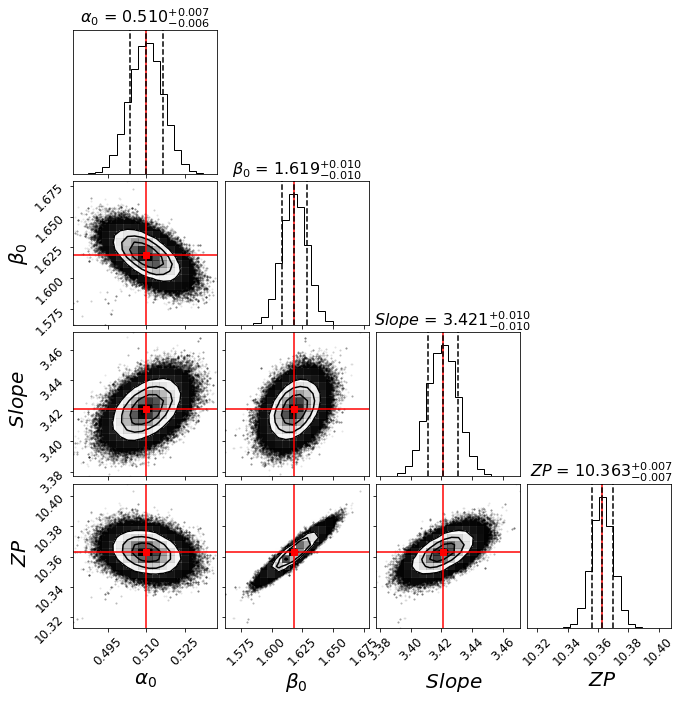

In [58]:
samples_ = samples_[np.where(samples_[:,0]>0.48)]

samples_ = samples_[(samples_[:,1]>1.56)&(samples_[:,1]<1.68)]
# samples_ = samples_[np.where(samples_[:,2]>4)]
samples_ = samples_[np.where(samples_[:,3]>10.31)]


# samples_[:,1] -= 0.4*4.58

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples_, 
                            [16, 50, 84],
                            axis=0)))

labels = [r"$\alpha_0$", r"$\beta_0$", r"$\/\/\/\/Slope$", r"$\/\/ZP$"]
# labels = [r"$\alpha_0$", r"$\/\/\/\/Slope$", r"$\/\/ZP$"]

truths=[t[0] for t in theta]
fig = corner.corner(samples_, truth_color='r', labels=labels,
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 16}, 
                    title_fmt=".3f")


for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(20)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(20)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(20)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)



In [26]:
len(df)

10154

5152

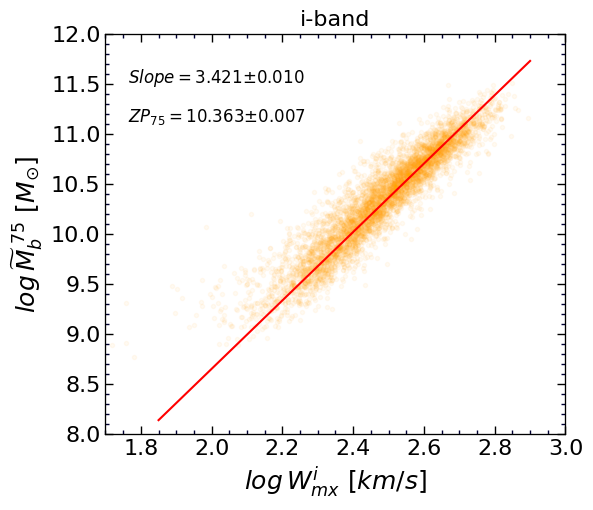

In [27]:
alfa = 0.510
beta = 1.619
m0 = 3.421
dm0 = 0.010
b0 = 10.363
db0 = 0.007
m, b, mc = malmquister(df, alfa, beta)

df['logMs_i'] = beta + alfa*df.gi - 0.4*df['Mi_75']
df['Ms_i'] = 10**df.logMs_i
df['Mb'] = df.Ms_i + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)
    
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]#.dropna()

logW = dff.lgWmxi.values
logMass = np.log10(dff.Mb.values)

ax.plot(logW, logMass, '.', color='orange', alpha=0.05) 
# ax.plot(logW, logMass, 'ko', alpha=0.6, ms=1.2, mfc='orange', mec='none') 


w = np.linspace(1.85,2.9,100)
M = m0*(w-2.5) + b0

ax.plot(w, M, 'r-')


ax.set_title("i-band", fontsize=16)


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.85*Xlm[0]+0.15*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.8*Ylm[1]
ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')



ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{\/\/75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

len(logW)

In [28]:
malmquister(df, 0.541, 1.603)

(2.403401200548313, -5.0404298531728315, -6.010017741586715e-05)

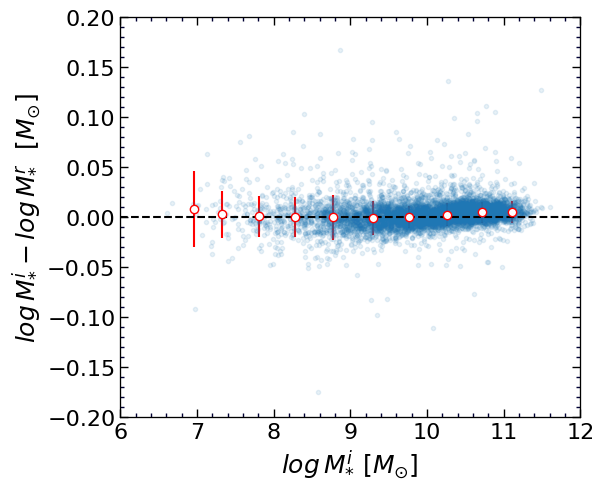

In [167]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75']
df['logMs_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75']
df['logMs_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75']

# df['logMs_i2'] = 2.404 + 0.101*df.iw1 - 0.4*df['Mi_75']
# df['logMs_w1'] = 1.928 + 0.035*df.mu50 - 0.4*df['M1_75']

ax.plot(df.logMs_i.values, df.logMs_i.values-df.logMs_r.values, '.', alpha=0.1)
# ax.plot(df.logMs_i.values, df.logMs_z.values, 'r.')
# ax.plot(df.logMs_i.values, df.logMs_w1.values, 'g.')

ax.plot([6,12],[0,0], 'k--')

ax.set_ylabel(r'$log \/ M_{*}^i - log\/M_{*}^r \/\/\/\/[M_{\odot}]$', fontsize=18) 
ax.set_xlabel(r'$log \/ M_{*}^i \/\/[M_{\odot}]$', fontsize=18) 

set_axes(ax, (6,12), (-0.2,0.2))



X = df.logMs_i.values
Y = df.logMs_i.values-df.logMs_r.values

for i in np.arange(6.5,11.5 , 0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='red', ms=6, mfc='white') 

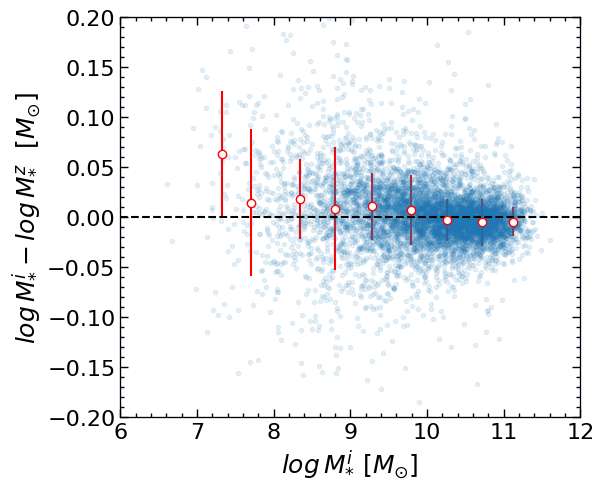

In [168]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['logMs_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75']
df['logMs_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75']
df['logMs_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75']

# df['logMs_i2'] = 2.404 + 0.101*df.iw1 - 0.4*df['Mi_75']
# df['logMs_w1'] = 1.928 + 0.035*df.mu50 - 0.4*df['M1_75']

ax.plot(df.logMs_i.values, df.logMs_i.values-df.logMs_z.values, '.', alpha=0.1)
# ax.plot(df.logMs_i.values, df.logMs_z.values, 'r.')
# ax.plot(df.logMs_i.values, df.logMs_w1.values, 'g.')

ax.plot([6,12],[0,0], 'k--')

ax.set_ylabel(r'$log \/ M_{*}^i - log\/M_{*}^z \/\/\/\/[M_{\odot}]$', fontsize=18) 
ax.set_xlabel(r'$log \/ M_{*}^i \/\/[M_{\odot}]$', fontsize=18) 

set_axes(ax, (6,12), (-0.2,0.2))



X = df.dropna().logMs_i.values
Y = df.dropna().logMs_i.values-df.dropna().logMs_z.values

for i in np.arange(6.5,11.5 , 0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='red', ms=6, mfc='white') 

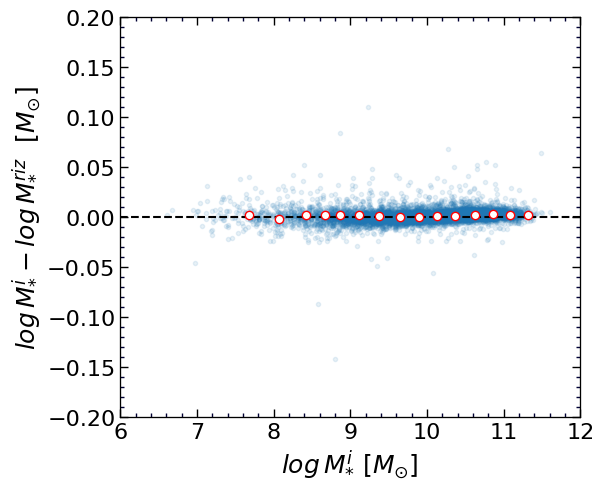

In [185]:
df['MtoL_w1_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75'] + 0.4*df['M1_75'] - (0.4*5.91) 
df['MtoL_w1_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75'] + 0.4*df['M1_75'] - (0.4*5.91) 
df['MtoL_w1_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75'] + 0.4*df['M1_75'] - (0.4*5.91) 

# df['MtoL_w1'] = (df.MtoL_w1_r+df.MtoL_w1_i+df.MtoL_w1_z)/3.
df['MtoL_w1'] = (df.MtoL_w1_r+df.MtoL_w1_i)/2.

# df['logMs_riz'] = (df.logMs_r+df.logMs_i+df.logMs_z)/3.
df['logMs_riz'] = (df.logMs_r+df.logMs_i)/2.


fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1


ax.plot(df.logMs_i.values, df.logMs_i.values-df.logMs_riz.values, '.', alpha=0.1)

ax.plot([6,12],[0,0], 'k--')

ax.set_ylabel(r'$log \/ M_{*}^i - log\/M_{*}^{riz} \/\/\/\/[M_{\odot}]$', fontsize=18) 
ax.set_xlabel(r'$log \/ M_{*}^i \/\/[M_{\odot}]$', fontsize=18) 

set_axes(ax, (6,12), (-0.2,0.2))



X = df.dropna().logMs_i.values
Y = df.dropna().logMs_i.values-df.dropna().logMs_riz.values

for i in np.arange(6.,12 , 0.25):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.25:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(yp, 0.1)
        Q3 = np.quantile(yp, 0.9)
        
        xp = xp[((yp>Q1)&(yp<Q3))]
        yp = yp[((yp>Q1)&(yp<Q3))]
              
        if len(xp)>5:
            
            x  = np.median(xp)
            y  = np.median(yp)
            yerr = np.std(yp)
            
            ax.errorbar(x, y, yerr=yerr, fmt='o', 
                    color='red', ms=6, mfc='white') 



(<matplotlib.axes._subplots.AxesSubplot at 0x7f9dae22cc40>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9dae6ea370>)

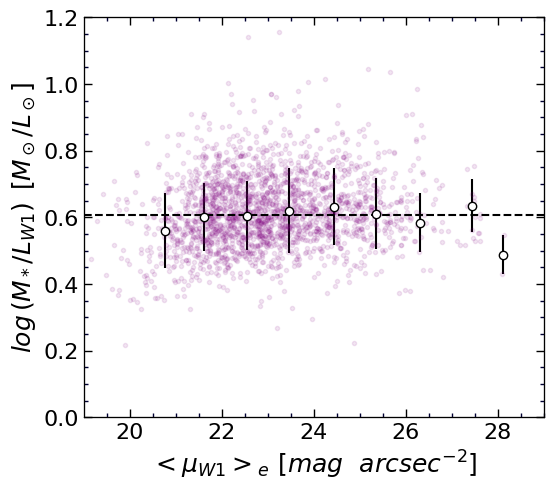

In [186]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(df.mu50_w1.values, 10**df.MtoL_w1.values, '.', alpha=0.1, color='purple')
# ax.set_ylim(1,3)

X = df.dropna().mu50_w1.values
Y = 10**df.dropna().MtoL_w1.values

for i in np.arange(20,30 , 1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='k', ms=6, mfc='white') 


np.median(df.dropna().MtoL_w1.values), np.median(10**df.dropna().MtoL_w1.values)
ups = np.median(10**df.dropna().MtoL_w1.values)

ax.set_xlabel(r'$<\mu_{W1}>_e \/\/[mag\/\/\ arcsec^{-2}]$', fontsize=18) 
ax.set_ylabel(r'$log \/ (M_*/L_{W1}) \/\/\/ [M_\odot/L_\odot]$', fontsize=18)


ax.plot([19,29],[ups,ups], '--', color='k')

set_axes(ax, (19,29), (0,1.2))


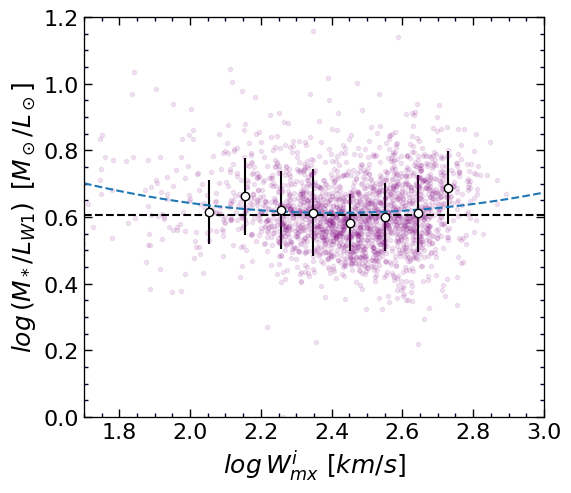

In [187]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(df.lgWmxi.values, 10**df.MtoL_w1.values, '.', alpha=0.1, color='purple')
# ax.set_ylim(1,3)

X = df.dropna().lgWmxi.values
Y = 10**df.dropna().MtoL_w1.values

for i in np.arange(2, 2.8 , 0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='k', ms=6, mfc='white') 


ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ (M_*/L_{W1}) \/\/\/ [M_\odot/L_\odot]$', fontsize=18)


ax.plot([1.7, 3],[ups,ups], '--', color='k')

set_axes(ax, (1.7,3), (0,1.2))


from scipy import polyval, polyfit
from scipy.optimize import curve_fit

def linfit(x, m, b):
    return m * x + b

def quadfit(x, m, n, b):
    return m * x**2 + n * x + b 

def linfit_b(x, m):
    return m * x

## When the slope is fixed, 'b' the intercept is variable
def linfit_m(x, b):
    return x+b


fit, cov = curve_fit(quadfit, X, Y, sigma=Y*0+0.001)
x = np.linspace(1.7,3,50)
y = quadfit(x, fit[0], fit[1], fit[2])
ax.plot(x,y, '--')

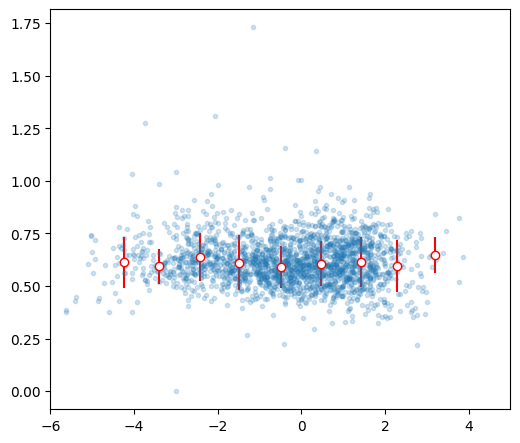

In [188]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(df.P0_w2.values, 10**df.MtoL_w1.values, '.', alpha=0.2)
# ax.set_ylim(-1,0.5)
ax.set_xlim(-6,5)


X = df.dropna().P0_w2.values
Y = 10**df.dropna().MtoL_w1.values

for i in np.arange(-5, 4 ,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='red', ms=6, mfc='white') 

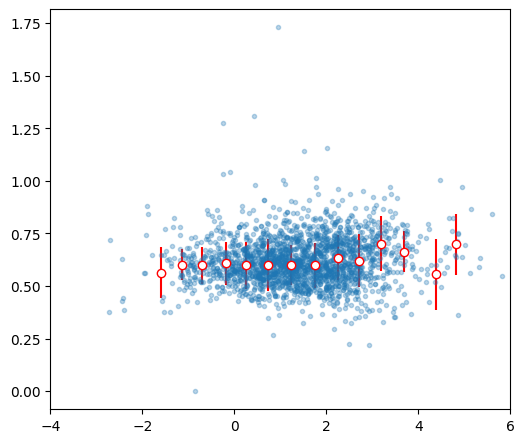

In [189]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(df.c21w.values, 10**df.MtoL_w1.values, '.', alpha=0.3)
# ax.set_ylim(-1,0.5)
ax.set_xlim(-4,6)

X = df.dropna().c21w.values
Y = 10**df.dropna().MtoL_w1.values

for i in np.arange(-2,5 ,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='red', ms=6, mfc='white') 

Text(0.5, 0, '$m_{21} - W_2 \\/\\/[mag]$')

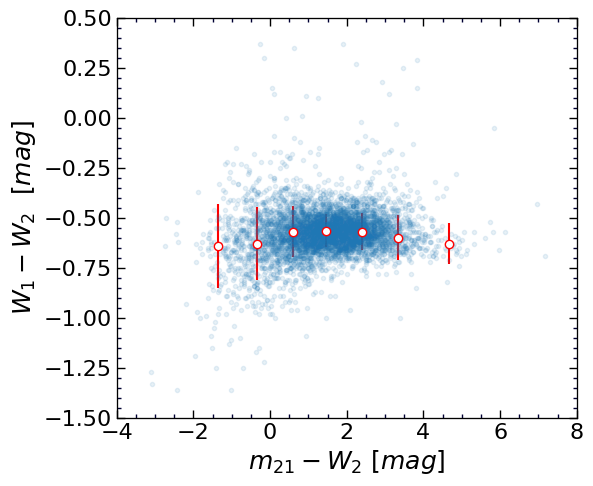

In [190]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['w12'] = df['w1***'] - df['w2_sss']

ax.plot(df.c21w.values, df.w12.values, '.', alpha=0.1)

X = df.dropna().c21w.values
Y = df.dropna().w12.values

for i in np.arange(-2,5,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='red', ms=6, mfc='white') 
        
        
set_axes(ax, (-4,8), (-1.5,0.5))


ax.set_ylabel(r'$W_1-W_2 \/\/\ [mag]$', fontsize=18) 
ax.set_xlabel(r'$m_{21} - W_2 \/\/[mag]$', fontsize=18) 

Text(0.5, 0, '$<\\mu_{W1}>_e \\/\\/[mag\\/\\/\\ arcsec^{-2}]$')

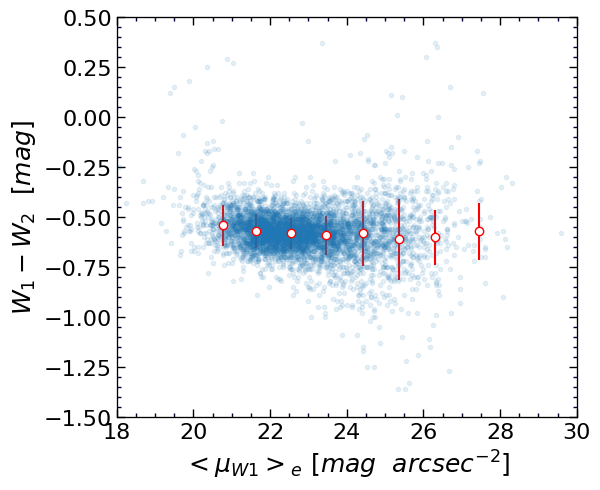

In [191]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['w12'] = df['w1***'] - df['w2_sss']

ax.plot(df.mu50_w1.values, df.w12.values, '.', alpha=0.1)

X = df.dropna().mu50_w1.values
Y = df.dropna().w12.values

for i in np.arange(20,28,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='red', ms=6, mfc='white') 
        
        
set_axes(ax, (18,30), (-1.5,0.5))


ax.set_ylabel(r'$W_1-W_2 \/\/\ [mag]$', fontsize=18) 
ax.set_xlabel(r'$<\mu_{W1}>_e \/\/[mag\/\/\ arcsec^{-2}]$', fontsize=18) 

Text(0.5, 0, '$<\\mu_{W2}>_e \\/\\/[mag\\/\\/\\ arcsec^{-2}]$')

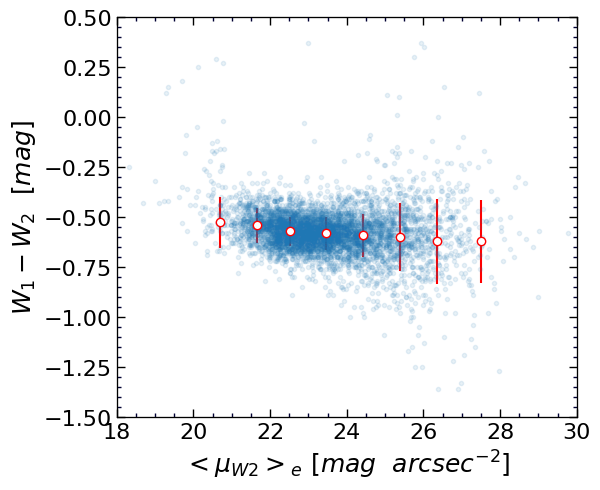

In [192]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

df['w12'] = df['w1***'] - df['w2_sss']

ax.plot(df.mu50.values, df.w12.values, '.', alpha=0.1)

X = df.dropna().mu50.values
Y = df.dropna().w12.values

for i in np.arange(20,28,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='red', ms=6, mfc='white') 
        
        
set_axes(ax, (18,30), (-1.5,0.5))


ax.set_ylabel(r'$W_1-W_2 \/\/\ [mag]$', fontsize=18) 
ax.set_xlabel(r'$<\mu_{W2}>_e \/\/[mag\/\/\ arcsec^{-2}]$', fontsize=18) 

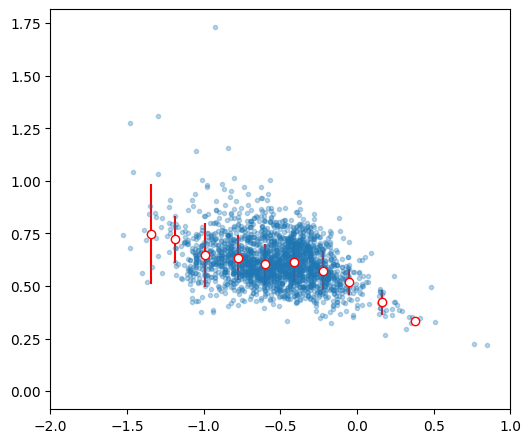

In [193]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(df.iw1.values, 10**df.MtoL_w1.values, '.', alpha=0.3)
# ax.set_ylim(-1,0.5)
ax.set_xlim(-2,1)

X = df.dropna().iw1.values
Y = 10**df.dropna().MtoL_w1.values

for i in np.arange(-1.5, 0.5 , 0.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.2:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='red', ms=6, mfc='white') 

[-0.68042187  0.21894549  0.98000002  0.96122919] [[ 0.03779245  0.02043892 -0.00439785  0.0089551 ]
 [ 0.02043892  0.01109317 -0.00232055  0.0048431 ]
 [-0.00439785 -0.00232055  0.00069983 -0.00114506]
 [ 0.0089551   0.0048431  -0.00114506  0.00287903]]


Text(-0.03, 0.5511031705888371, '0.53')

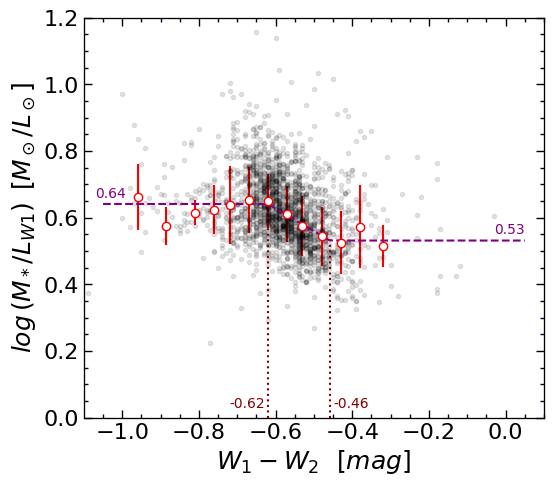

In [194]:
df['w12'] = df['w1***'] - df['w2_sss']

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(df.w12.values, 10**df.MtoL_w1.values, 'k.', alpha=0.1)

set_axes(ax, (-1.1,0.1), (0,1.2))

ax.set_xlabel(r'$W_1-W_2 \/\/\ [mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/ (M_*/L_{W1}) \/\/\/ [M_\odot/L_\odot]$', fontsize=18)


X = df.dropna().w12.values
Y = 10**df.dropna().MtoL_w1.values

Xl = []
Yl = []
Yle = []
Ylerr = []

for i in np.arange(-1.0, 0, 0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(yp, 0.005)
        Q3 = np.quantile(yp, 0.995)
        
        xp = xp[((yp>Q1)&(yp<Q3))]
        yp = yp[((yp>Q1)&(yp<Q3))]
              
        if len(xp)>5:
            
            x  = np.median(xp)
            y  = np.median(yp)
            yerr = np.std(yp)
            
            ax.errorbar(x, y, yerr=yerr, fmt='o', 
                    color='red', ms=6, mfc='white') 
            
            Xl.append(x)
            Yl.append(y)
            Yle.append(np.std(yp)/np.sqrt(len(yp)))
            Ylerr.append(yerr)
            
Xl  = np.asarray(Xl)
Yl  = np.asarray(Yl)            
Yle = np.asarray(Yle)       
Ylerr = np.asarray(Ylerr)     
        
from scipy import polyval, polyfit
from scipy.optimize import curve_fit

def biLinfit(x, m, b, x1, d):
    
    x1 = x1-1-0.60
    d  = d-1+0.2
    x2 = x1 + d
    
    y = m*x+b
    y1 = m*x1+b
    y2 = m*x2+b
    
    y[x<x1] = y1
    y[x>x2] = y2
    
    return y


# X = X[((Y>0.2)&(Y<1))]
# Y = Y[((Y>0.2)&(Y<1))]

# Y = Y[((X>-1)&(X<0))]
# X = X[((X>-1)&(X<0))]

fit, cov = curve_fit(biLinfit, Xl, Yl, sigma=Yle)
x = np.linspace(-1.05,0.05, 100)
(m, b, x1, d) = fit
y = biLinfit(x, fit[0], fit[1], fit[2], fit[3])
ax.plot(x,y, '--', color='purple')

print(fit, cov)

x1 = x1-1-0.60
d  = d-1 + 0.2
x2 = x1 + d
y1 = m*x1+b
y2 = m*x2+b

ax.plot([x1,x1],[0,y1], ':', color='maroon')
ax.plot([x2,x2],[0,y2], ':', color='maroon')

ax.text(x1-0.10,0.03,"%.2f"%x1, fontsize=10, color='maroon')
ax.text(x2+0.01,0.03,"%.2f"%x2, fontsize=10, color='maroon')


ax.text(-1.07,y1+0.02,"%.2f"%y1, fontsize=10, color='purple')
ax.text(-0.03,y2+0.02,"%.2f"%y2, fontsize=10, color='purple')

In [195]:
df.columns

Index(['flag', 'DM_av', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'PGC1', 'Nest',
       'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel', 'V3k', 'v3k', 'f',
       'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc', 'g***', 'r***', 'i***',
       'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE', 'GLong', 'GLat', 'SGL', 'SGB',
       'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg', 'Vlsg', 'V3kg', 'fg', 'w1_sss',
       'w2_sss', 'mu50', 'P0_w2', 'c21w', 'Wba', 'R50_w1', 'R50_w2', 'mu50_w1',
       'Vmod', 'D75', 'logD75', 'DM_75', 'Mg_75', 'Mr_75', 'Mi_75', 'Mz_75',
       'M1_75', 'gi', 'iw1', 'F', 'e_F', 'Flux', 'F21_av', 'Mass_HI',
       'logMs_i', 'Ms_i', 'logMs_av', 'Mb', 'logMs_r', 'MtoL_w1', 'w12',
       'MtoL_w1_r', 'MtoL_w1_i', 'MtoL_w1_z', 'logMs_z', 'MtoL_w1_av3'],
      dtype='object')

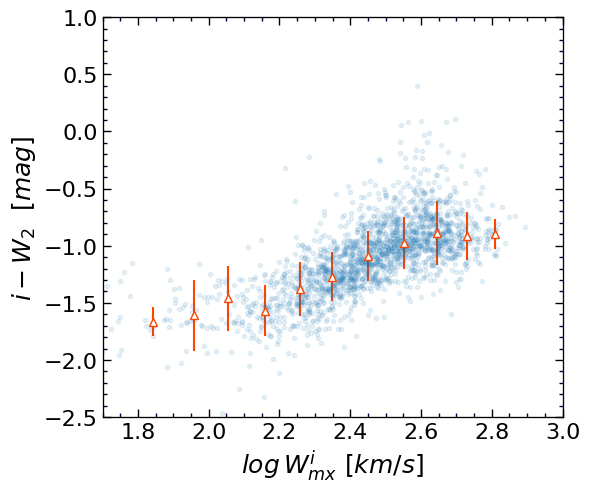

In [196]:
df['w12'] = df['i***'] - df['w2_sss']

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Mass_HI>0)&(df['w1***']>0)&(df['w2_sss']>0)&(df.inc<90)]

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(dff.lgWmxi.values, dff.w12.values, '.', alpha=0.1)

set_axes(ax, (1.7,3), (-2.5,1))

ax.set_ylabel(r'$i-W_2 \/\/\ [mag]$', fontsize=18) 
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 


X = dff.dropna().lgWmxi.values
Y = dff.dropna().w12.values

for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.01)
        Q3 = np.quantile(xp, 0.90)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='^', 
                    color='orangered', ms=6, mfc='white') 

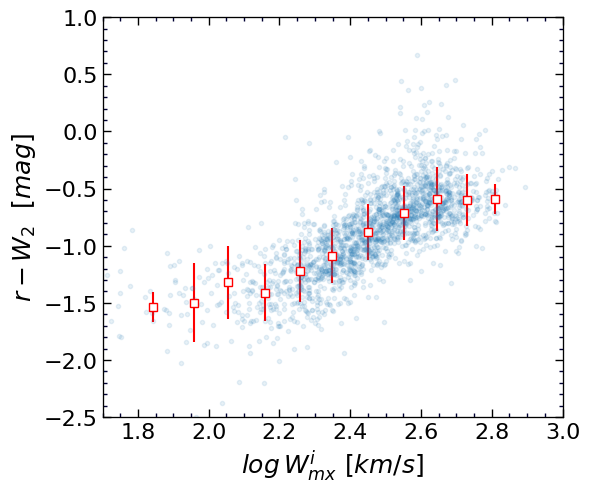

In [197]:
df['w12'] = df['r***'] - df['w2_sss']

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Mass_HI>0)&(df['w1***']>0)&(df['w2_sss']>0)&(df.inc<90)]

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(dff.lgWmxi.values, dff.w12.values, '.', alpha=0.1)

set_axes(ax, (1.7,3), (-2.5,1))

ax.set_ylabel(r'$r-W_2 \/\/\ [mag]$', fontsize=18) 
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 


X = dff.dropna().lgWmxi.values
Y = dff.dropna().w12.values

for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.01)
        Q3 = np.quantile(xp, 0.90)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='s', 
                    color='red', ms=6, mfc='white') 

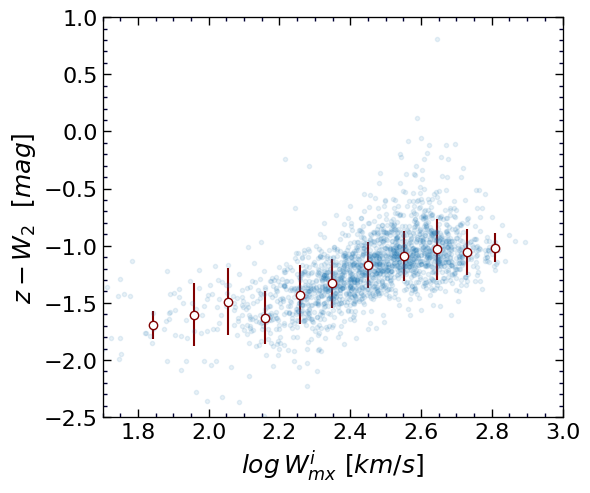

In [198]:
df['w12'] = df['z***'] - df['w2_sss']

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Mass_HI>0)&(df['w1***']>0)&(df['w2_sss']>0)&(df.inc<90)]

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(dff.lgWmxi.values, dff.w12.values, '.', alpha=0.1)

set_axes(ax, (1.7,3), (-2.5,1))

ax.set_ylabel(r'$z-W_2 \/\/\ [mag]$', fontsize=18) 
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 


X = dff.dropna().lgWmxi.values
Y = dff.dropna().w12.values

for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.01)
        Q3 = np.quantile(xp, 0.90)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='maroon', ms=6, mfc='white') 

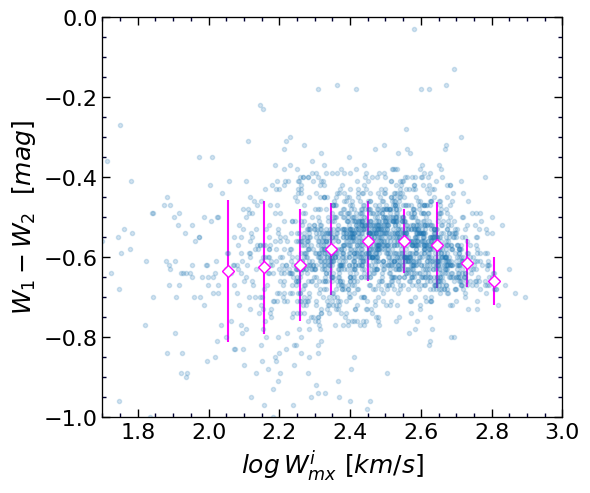

In [199]:
df['w12'] = df['w1***'] - df['w2_sss']

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Mass_HI>0)&(df['w1***']>0)&(df['w2_sss']>0)&(df.inc<90)]


fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(dff.lgWmxi.values, dff.w12.values, '.', alpha=0.2)

set_axes(ax, (1.7,3), (-1,0))

ax.set_ylabel(r'$W_1-W_2 \/\/\ [mag]$', fontsize=18) 
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 


X = dff.dropna().lgWmxi.values
Y = dff.dropna().w12.values

for i in np.arange(2,3, 0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.005)
        Q3 = np.quantile(xp, 0.995)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='D', 
                    color='magenta', ms=6, mfc='white') 

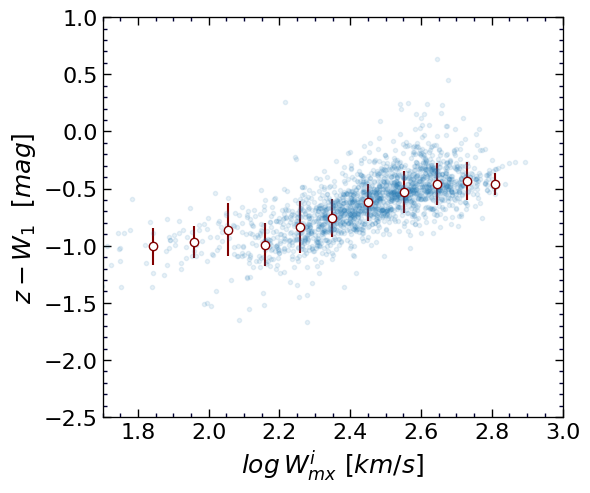

In [200]:
df['w12'] = df['z***'] - df['w1***']

dff = df[(df.Qw>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.Mass_HI>0)&(df['w1***']>0)&(df['w2_sss']>0)&(df.inc<90)]

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(dff.lgWmxi.values, dff.w12.values, '.', alpha=0.1)

set_axes(ax, (1.7,3), (-2.5,1))

ax.set_ylabel(r'$z-W_1 \/\/\ [mag]$', fontsize=18) 
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 


X = dff.dropna().lgWmxi.values
Y = dff.dropna().w12.values

for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        
        
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        
        Q1 = np.quantile(xp, 0.01)
        Q3 = np.quantile(xp, 0.90)
        
        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), fmt='o', 
                    color='maroon', ms=6, mfc='white') 